### Sales Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read data
sales_df = pd.read_excel(r"C:\Users\Timothy Lim\Dropbox\Tim Y4S2\BT4222\Project\apple sales data.xlsx", 
                         sheet_name='Data', engine='openpyxl', usecols="B:E", skiprows=4,
                        names=['Quarter', 'iPhone', 'iPad', 'Mac'])

sales_df.head()

,Quarter,iPhone,iPad,Mac
0,1Q '12,37.04,15.43,5.20
1,2Q '12,35.06,11.80,4.02
2,3Q '12,26.03,17.04,4.02
3,4Q '12,26.91,14.04,4.92
4,1Q '13,47.79,22.86,4.06


In [3]:
sales_df.dtypes

Quarter     object
iPhone     float64
iPad       float64
Mac        float64
dtype: object

In [4]:
sales_df.shape

(28, 4)

In [5]:
sales_df.describe()

,iPhone,iPad,Mac
count,28.000000,28.000000,28.000000
mean,47.218214,13.751071,4.640357
std,14.433032,4.362983,0.611692
min,26.030000,8.920000,3.720000
25%,37.332500,10.310000,4.075000
50%,46.095000,12.850000,4.565000
75%,51.070000,15.602500,5.225000
max,78.290000,26.040000,5.710000


Data represents unit sales of Apple worldwide by product / operating segment.

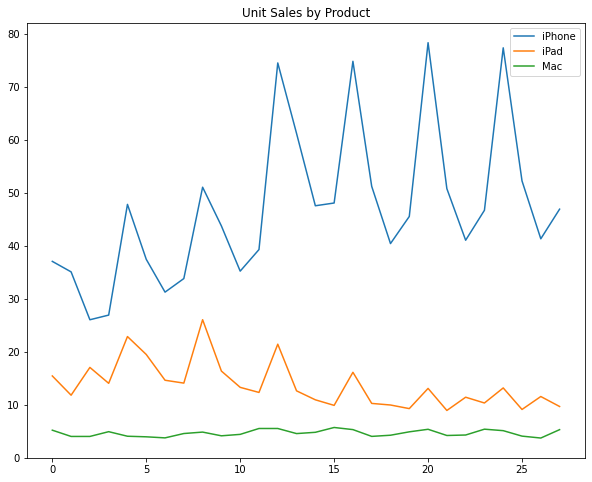

In [6]:
# plot sales
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(10, 8))
axes.plot(sales_df.index, sales_df['iPhone'], label='iPhone')
axes.plot(sales_df.index, sales_df['iPad'], label='iPad')
axes.plot(sales_df.index, sales_df['Mac'], label='Mac')
axes.set_title("Unit Sales by Product")
axes.legend()

plt.show()

C:\Users\Timothy Lim\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


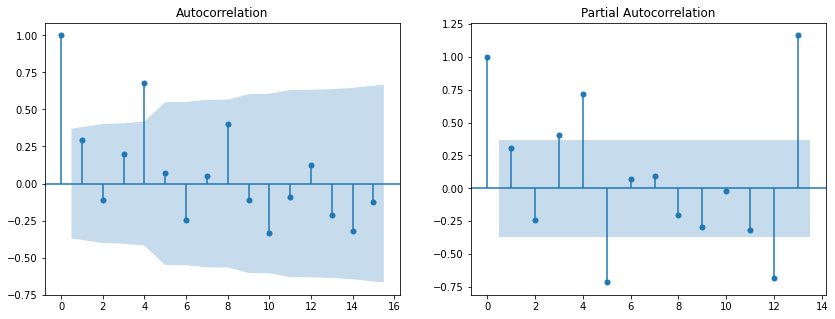

In [7]:
# acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(data):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    plot_acf(data, ax=axes[0])
    plot_pacf(data, lags=13, ax=axes[1])
    plt.show()

# iphone
plot_acf_pacf(sales_df['iPhone'])

C:\Users\Timothy Lim\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


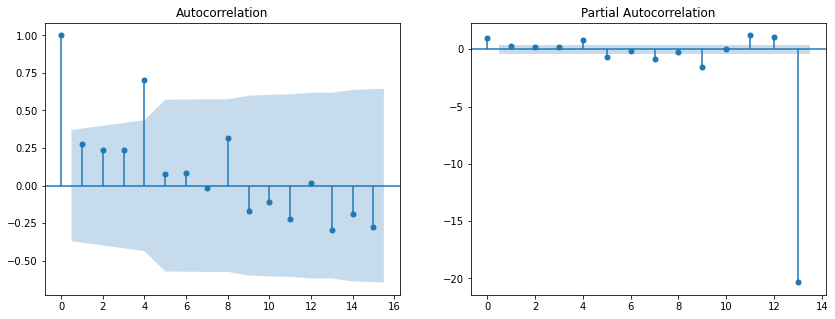

In [8]:
# iPad
plot_acf_pacf(sales_df['iPad'])

C:\Users\Timothy Lim\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


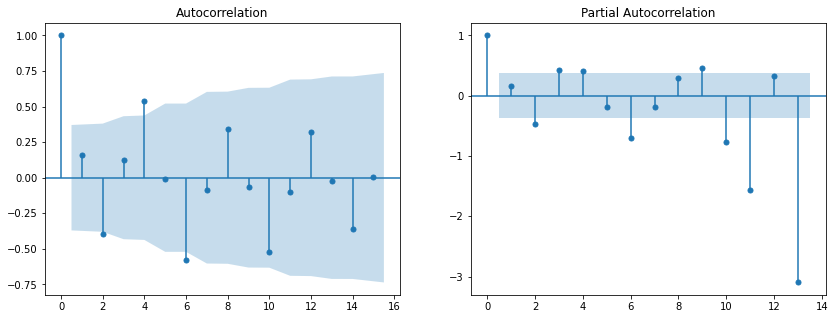

In [9]:
# mac
plot_acf_pacf(sales_df['Mac'])

ACF shows the correlation coefficients between a time series and its lagged values. Useful for identifying the order of MA term. 

PACF isolates the effects of time lag t-n on time t.  Useful for identifying the order of AR term.   
eg. regress y(t) = y(t-1) + y(t-2) + y(t-3), then PACF for time lag 3 is the coefficient of y(t-3). or something like this..

For all product lines, we can see that the ACF at the 4th lag is strongly positive. We should consider adding a seasonal component of size=4, since this corresponds to a year's worth of data also. 

Not sure about the PACF plots lol

https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/  

https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

Anyway just use a grid search to find the optimal parameters for the time series. 

### Identifying SARIMA Order

In [10]:
# split train-test

train_size = 0.7
train_idx = int(train_size * len(sales_df))
train_df = sales_df.iloc[:train_idx]
test_df = sales_df.iloc[train_idx:]

print(train_df.shape)
print(test_df.shape)

(19, 4)
(9, 4)


In [11]:
train_df.tail()

,Quarter,iPhone,iPad,Mac
14,3Q '15,47.53,10.93,4.80
15,4Q '15,48.05,9.88,5.71
16,1Q '16,74.78,16.12,5.31
17,2Q '16,51.19,10.25,4.03
18,3Q '16,40.40,9.95,4.25


In [12]:
test_df.head()

,Quarter,iPhone,iPad,Mac
19,4Q '16,45.51,9.27,4.89
20,1Q '17,78.29,13.08,5.37
21,2Q '17,50.76,8.92,4.20
22,3Q '17,41.03,11.42,4.29
23,4Q '17,46.68,10.33,5.39


In [20]:
# specify range of values to iterate over
param_space = {'p': range(0, 5),  # AR terms
               'd': range(0, 2), 
               'q': range(0, 5), # MA terms
               'P': range(0, 5), 
               'D': range(0, 2),
               'Q': range(0, 5), 
               's': range(4, 12, 4)
              }

n_comb = 1
for v in param_space.items():
    n_comb *= len(v)

print(f'no. of models to try: {n_comb}')

no. of models to try: 128


In [21]:
import itertools as it
combinations = it.product(*(param_space[param] for param in param_space))
len(list(combinations))

5000

In [95]:
param_space

{'p': range(0, 5),
 'd': range(0, 2),
 'q': range(0, 5),
 'P': range(0, 5),
 'D': range(0, 2),
 'Q': range(0, 5),
 's': range(4, 12, 4)}

In [110]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools as it
import progressbar
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings('ignore')

def find_order(data, param_space, metric='mse'):
    '''
    helper method to return the best parameters for the SARIMAX model
    '''
    # convert param space into iterable
    combinations = it.product(*(param_space[param] for param in param_space))
    
    results_df = pd.DataFrame(columns=['p', 'd', 'q', 'P', 'D', 'Q', 'm', 'eval_metric'])
    
    bar = progressbar.ProgressBar(maxval=len(list(it.product(*(param_space[param] for param in param_space)))), 
                                  widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    i = 0
    for combi in combinations:
        bar.update(i+1)
        # unpack parameters
        p = combi[0]
        d = combi[1]
        q = combi[2]
        
        P = combi[3]
        D = combi[4]
        Q = combi[5]
        m = combi[6]
       
        try:
            model = SARIMAX(endog=data, order=(p, d, q), seasonal_order=(P, D, Q, m),
                            trend='t', enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
        except: # give up
            continue
        
        if metric=='mse':
            fit_result = model_fit.mse
        if metric=='aic':
            fit_result = model_fit.aic
        if metric=='bic':
            fit_result = model_fit.bic
        
        # update results
        results_df.loc[len(results_df)] = [p, d, q, P, D, Q, m, fit_result]
        i += 1

    bar.finish()
    return results_df

iphone_order = find_order(train_df['iPhone'], param_space)

[========================================================================] 100%


In [113]:
iphone_order

,p,d,q,P,D,Q,m,eval_metric
0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,376.224812
1,0.0,0.0,0.0,0.0,0.0,0.0,8.0,376.224812
2,0.0,0.0,0.0,0.0,0.0,1.0,4.0,351.513598
3,0.0,0.0,0.0,0.0,0.0,1.0,8.0,386.725053
4,0.0,0.0,0.0,0.0,0.0,2.0,4.0,388.175087
...,...,...,...,...,...,...,...,...
4259,4.0,1.0,4.0,4.0,1.0,0.0,8.0,146.038360
4260,4.0,1.0,4.0,4.0,1.0,1.0,8.0,146.038360
4261,4.0,1.0,4.0,4.0,1.0,2.0,8.0,146.038360
4262,4.0,1.0,4.0,4.0,1.0,3.0,8.0,146.038360


In [140]:
# generate one-step forecasts

def get_forecasts(train_data, test_data, order, seasonal_order, n_steps=1):
    '''
    generates n-step forecasts for each obs in test data
    '''
    pointer = 0
    y_pred = pd.Series()
    
    while pointer < len(test_data):

        model = SARIMAX(endog=train_data.append(test_data.iloc[:pointer]),
                       order=order,
                       seasonal_order=seasonal_order)
        res = model.fit()
        y_pred = y_pred.append(res.forecast(steps=n_steps))
        pointer += n_steps
    
    return y_pred

# iPhone sales forecasts
y_pred = get_forecasts(train_df['iPhone'], test_df['iPhone'],
                      (0, 1, 3), (3, 1, 1, 4))  

In [141]:
y_pred

19    41.622643
20    70.222499
21    57.585622
22    35.777736
23    46.223395
24    93.010837
25    46.398540
26    41.000251
27    45.481277
dtype: float64

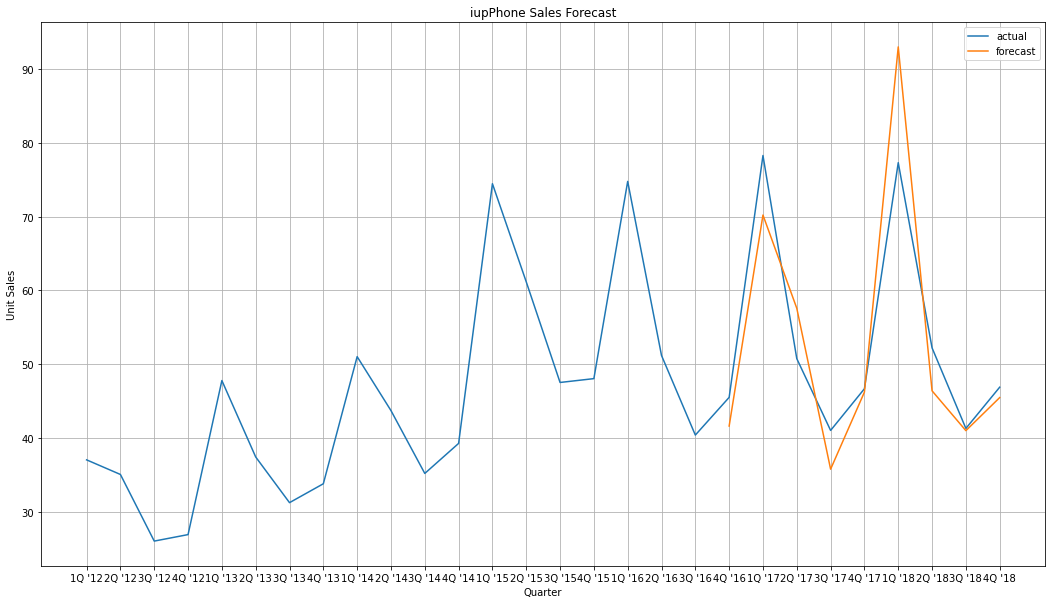

In [142]:
# plot
y_true = sales_df['iPhone']

fig, ax = plt.subplots(figsize=(18, 10))
plt.plot(sales_df['Quarter'], y_true, label='actual')
plt.plot(sales_df['Quarter'].iloc[train_idx:], y_pred, label='forecast')
plt.xlabel("Quarter")
plt.ylabel("Unit Sales")
plt.title("iupPhone Sales Forecast")
plt.grid(True)
plt.legend()

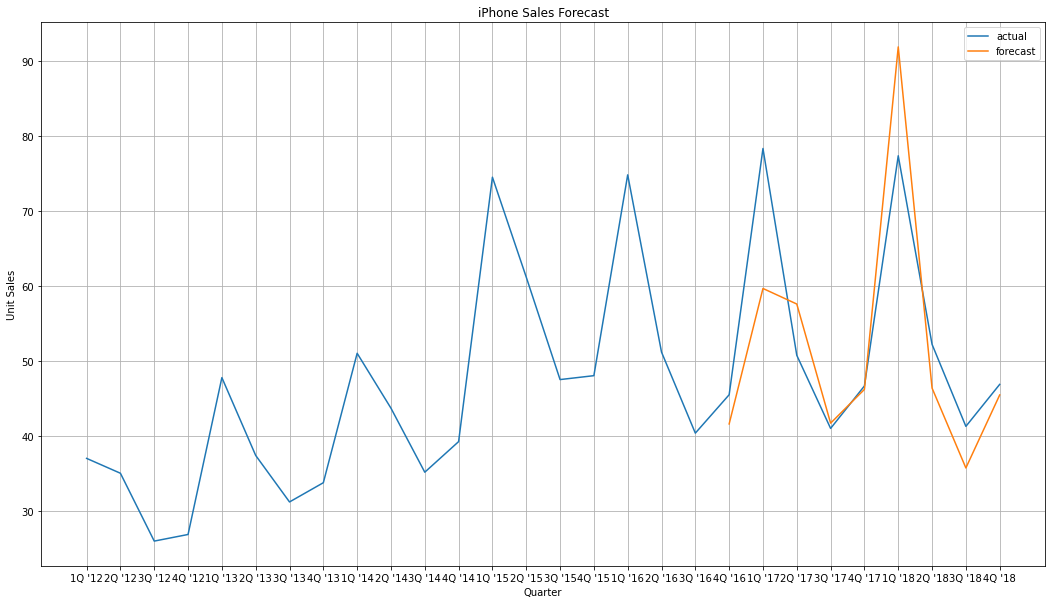

In [145]:
# two step forecasts
two_step = get_forecasts(train_df['iPhone'], test_df['iPhone'], (0, 1, 3), (3, 1, 1, 4), n_steps=2)

# plot
fig, ax = plt.subplots(figsize=(18, 10))
plt.plot(sales_df['Quarter'], y_true, label='actual')
plt.plot(sales_df['Quarter'].iloc[train_idx:], two_step.iloc[:-1], label='forecast')
plt.xlabel("Quarter")
plt.ylabel("Unit Sales")
plt.title("iPhone Sales Forecast")
plt.grid(True)
plt.legend()

In [88]:
ipad_order = find_order(train_df['iPad'], param_space)
mac_order = find_order(train_df['Mac'], param_space)

[========================================================================] 100%
[========================================================================] 100%


In [115]:
ipad_order.sort_values('eval_metric').head()

,p,d,q,P,D,Q,m,eval_metric
1140,1.0,0.0,2.0,1.0,0.0,0.0,4.0,19.724627
2408,2.0,1.0,1.0,0.0,1.0,1.0,4.0,20.064775
1696,1.0,1.0,3.0,1.0,0.0,0.0,4.0,20.461516
4149,4.0,1.0,3.0,0.0,0.0,0.0,8.0,20.463227
4148,4.0,1.0,3.0,0.0,0.0,0.0,4.0,20.463227


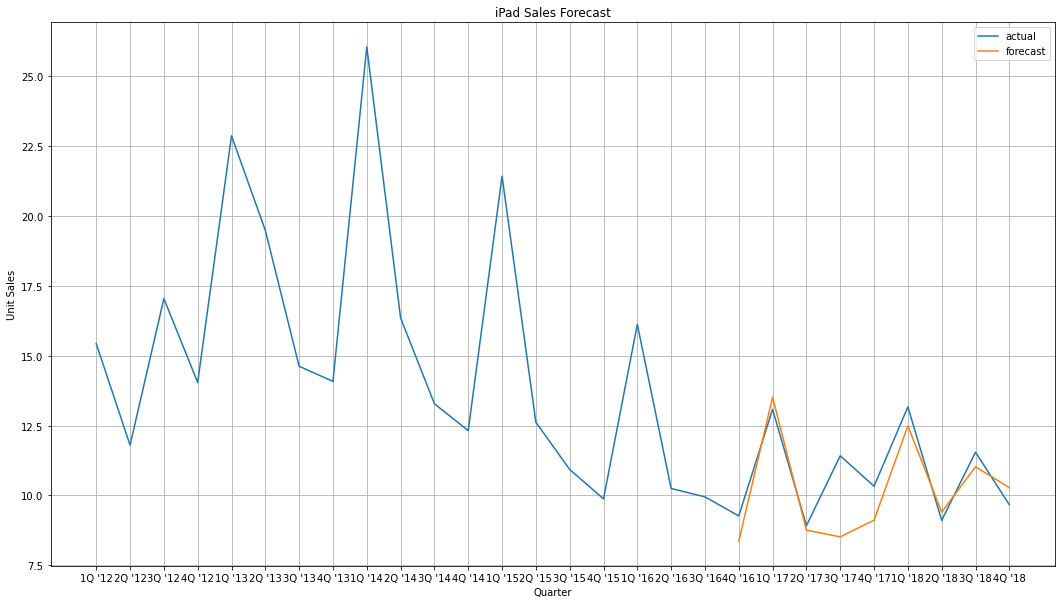

In [149]:
# iPad forecasts 
ipad_forecast = get_forecasts(train_df['iPad'], test_df['iPad'],
                             (1, 0, 2), (1, 0, 0, 4), n_steps=1)

# plot
fig, ax = plt.subplots(figsize=(18, 10))
plt.plot(sales_df['Quarter'], sales_df['iPad'], label='actual')
plt.plot(sales_df['Quarter'].iloc[train_idx:], ipad_forecast, label='forecast')
plt.xlabel("Quarter")
plt.ylabel("Unit Sales")
plt.title("iPad Sales Forecast")
plt.grid(True)
plt.legend()

In [116]:
mac_order.sort_values('eval_metric').head()

,p,d,q,P,D,Q,m,eval_metric
1680,1.0,1.0,3.0,0.0,0.0,0.0,4.0,1.611570
1681,1.0,1.0,3.0,0.0,0.0,0.0,8.0,1.611570
2140,2.0,0.0,3.0,0.0,0.0,0.0,4.0,1.649154
2141,2.0,0.0,3.0,0.0,0.0,0.0,8.0,1.649154
1842,2.0,0.0,0.0,0.0,0.0,1.0,4.0,1.679550


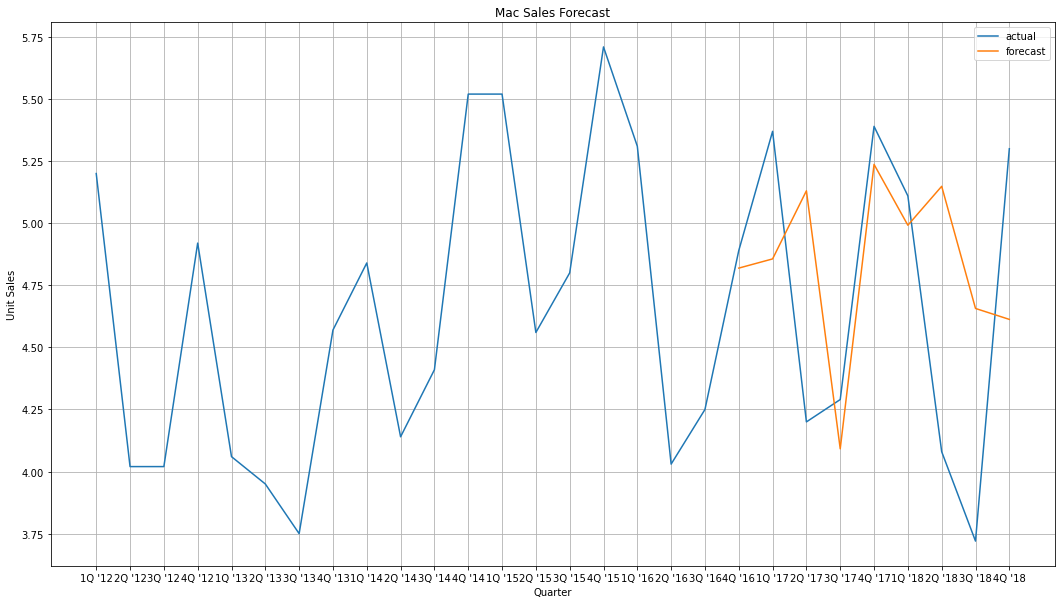

In [152]:
# mac forecasts 
mac_forecast = get_forecasts(train_df['Mac'], test_df['Mac'],
                             (1, 1, 3), (0, 0, 0, 4), n_steps=1)

# plot
fig, ax = plt.subplots(figsize=(18, 10))
plt.plot(sales_df['Quarter'], sales_df['Mac'], label='actual')
plt.plot(sales_df['Quarter'].iloc[train_idx:], mac_forecast, label='forecast')
plt.xlabel("Quarter")
plt.ylabel("Unit Sales")
plt.title("Mac Sales Forecast")
plt.grid(True)
plt.legend()

I think the forecasts are all decent...Mac forecasts look worse but I think its the scale of the y-axis that makes it look as such. 